# Results

In [23]:
# Import network graph
import lib.notebook_finder as notebook_finder
import autoencoder
from IPython.display import Image as iImage
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

# import packages from other notebook
exec(autoencoder.cells[0])

# import train/validation/test data
exec(autoencoder.cells[1])

Train shape: (15000, 128, 128), (15000, 128, 128)
Test shape: (2500, 128, 128), (2500, 128, 128)
Valid shape: (2500, 128, 128), (2500, 128, 128)


## Download trained checkpoint

In [2]:
# patch size used
exec(autoencoder.cells[2])

# Import network graph
exec(autoencoder.cells[3])
checkpoint = 'data/model_global_step_20000_chart_step_41.ckpt'

# Download pre-trained model
from urllib.request import urlretrieve
last_percent_reported = None
def reporthook(count, blockSize, totalSize):
    """ Report download progress """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    if last_percent_reported != percent:
        message = ("%s%%" % percent) if percent % 10 == 0 else "."
        print(message, end="")
        last_percent_reported = percent
urlretrieve('https://www.dropbox.com/s/6zqi7m74c5er6gj/model_global_step_20000_chart_step_41.ckpt?dl=1', 
            checkpoint, 
            reporthook=reporthook)
#urlretrieve('https://www.dropbox.com/s/a77iypie68ld34h/model_global_step_20000_chart_step_41.ckpt.meta?dl=1', 'data/model_global_step_20000_chart_step_41.ckpt.meta', reporthook=reporthook)


0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%

('data/model_global_step_20000_chart_step_41.ckpt',
 <http.client.HTTPMessage at 0x15234bef0>)

## Metrics

After 2000 steps, with 256 samples each, the total loss was: **0.003037**

And the metric chosen, the r2, was floating between 0.033 and 0.031 on the validation dataset.

In [6]:
# R2 function
exec(autoencoder.cells[4])

print("when images are the same: %f" % difference(np.array([0,1,0]), np.array([0,1,0])))
print("when images are completely different: %f" % difference(np.array([0,1,0]), np.array([1,0,1])))

def get_patches(dataset, labels, batch_start):
    """ Given an X,y array, return image patches """
    batch_data = np.empty((batch_size, patch_size[0]*patch_size[1]))
    batch_labels = np.empty((batch_size, patch_size_out[0]*patch_size_out[1]))
    
    for i in range(batch_size):
        
        # Stochastic optimizer
        x = random.randint(0, dataset.shape[1] - patch_size[0])
        y = random.randint(0, dataset.shape[2] - patch_size[1])
        patch_scale = float(patch_size_out[0])/patch_size[0]
        data_w = dataset[batch_start+i, x: x+patch_size[0], y: y+patch_size[1]]
        label_w = labels[
            batch_start+i, 
            x*patch_scale : (x+patch_size[0])*patch_scale, 
            y*patch_scale: (y+patch_size[1])*patch_scale
        ]

        batch_data[i] = np.array(data_w).reshape((1, batch_data.shape[1]))
        batch_labels[i] = np.array(label_w).reshape((1, batch_labels.shape[1]))
    return (batch_data, batch_labels)

with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    if not checkpoint is None:
        saver.restore(session, checkpoint)
        
        # Validation score
        valid_batches = int(X_valid.shape[0]/batch_size)
        v_total = []
        for i in range(valid_batches):
            offset = i * batch_size
            valid_data, valid_labels = get_patches(X_valid, y_valid, offset)
            valid_predictions = session.run(y_pred, feed_dict= {
                tf_X : valid_data
            })
            v_total.append(difference(valid_predictions, valid_labels))
        v_diff = sum(v_total) / len(v_total)

        # Test score
        t_total = []
        test_batches = int(X_test.shape[0]/batch_size)
        for i in range(test_batches):
            offset = i * batch_size
            test_data, test_labels = get_patches(X_test, y_test, offset)
            test_predictions = session.run(y_pred, feed_dict= {
                tf_X : test_data
            })
            t_total.append(difference(test_predictions, test_labels))
        t_diff = sum(t_total) / len(t_total)
        
        print("Test r2: %.3f" % t_diff)
        print("Validation r2: %.3f" % v_diff)


when images are the same: 0.000000
when images are completely different: 1.000000


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Test r2: 0.033
Validation r2: 0.032


## Show patches

### Train results

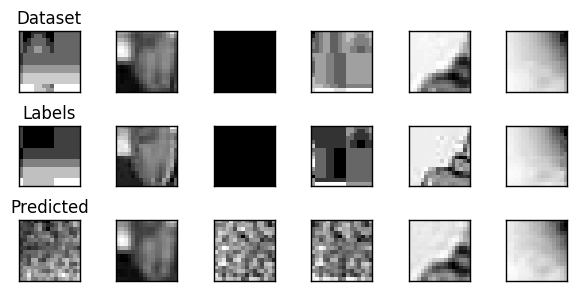

### Test results

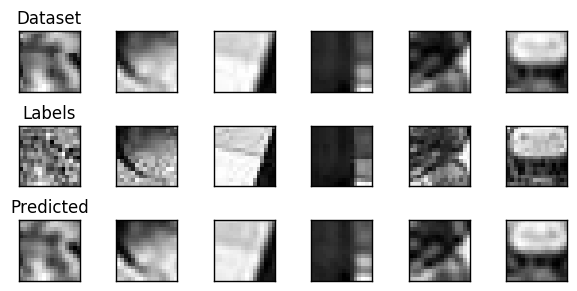

In [86]:
examples_to_show = 6
checkpoint = 'data/model_global_step_20000_chart_step_41.ckpt'

def show_plot(train, labels, predictions):
    """ Print an image grid """
    # Compare original images with their reconstructions
    f, a = plt.subplots(3, examples_to_show, figsize=(examples_to_show, 3))
    # Hide labels
    for axis in f.axes:
        axis.set_xticks([])
        axis.set_yticks([])
    # Row names
    for axis, row_name in zip(a[:,0], row_names):
        axis.set_title(row_name)

    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(train[i], patch_size), cmap="gray", interpolation="nearest")
        a[1][i].imshow(np.reshape(labels[i], patch_size_out), cmap="gray", interpolation="nearest")
        a[2][i].imshow(np.reshape(predictions[i], patch_size_out), cmap="gray", interpolation="nearest")
    f.tight_layout()
    plt.show()


with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    saver.restore(session, checkpoint)
    
    t_total = []
    train_batches = 3 # train n samples of 256 patches. We don't need everything to draw a graph
    for i in range(train_batches):
        offset = i * batch_size
        train_data, train_labels = get_patches(X_train, y_train, offset)
        train_predictions = session.run(y_pred, feed_dict= {
            tf_X : train_data
        })
        t_total.append(difference(train_predictions, train_labels))
    t_diff = sum(t_total) / len(t_total)
    train_diff.append(t_diff)

    # Validation score
    valid_batches = int(X_valid.shape[0]/batch_size)
    v_total = []
    for i in range(valid_batches):
        offset = i * batch_size
        valid_data, valid_labels = get_patches(X_valid, y_valid, offset)
        valid_predictions = session.run(y_pred, feed_dict= {
            tf_X : valid_data
        })
        v_total.append(difference(valid_predictions, valid_labels))
    v_diff = sum(v_total) / len(v_total)
    val_diff.append(v_diff)

    # Validation images
    random_batch = random.randint(0, valid_batches-1)
    valid_data, valid_labels = get_patches(X_valid, y_valid, random_batch * batch_size)
    valid_predictions = session.run(y_pred, feed_dict= {
        tf_X : valid_data
    })

    clear_output()

    display(Markdown("### Train results"))
    show_plot(train_data, train_labels, train_predictions)

    display(Markdown("### Test results"))
    show_plot(valid_data, valid_labels, valid_predictions)



## Recompose an image

## Low-res

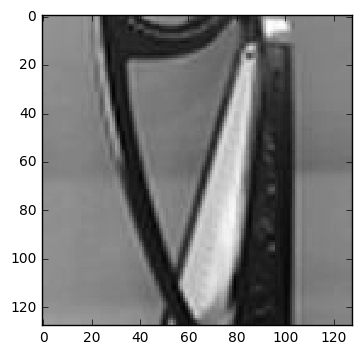

## Optimized

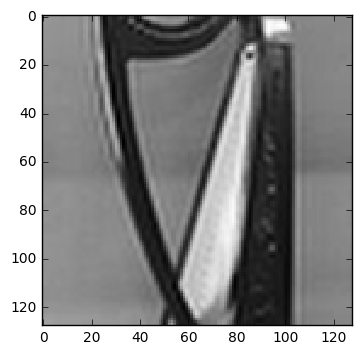

## High-res

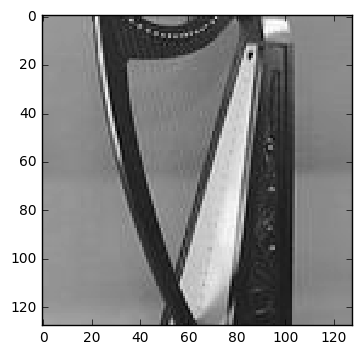

In [87]:

with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    if not checkpoint is None:
        saver.restore(session, checkpoint)
    
    # Pick a random image from the test set
    r = random.randint(0, X_test.shape[0])
    image = X_test[r]
    label = y_test[r]
    
    # Show it
    display(Markdown("## Low-res"))
    plt.figure(figsize = (4, 4))
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.show()
    
    # Break it into small patches to be able to process it
    data = extract_patches_2d(image, patch_size)
    data = data.reshape((-1, patch_size[0]*patch_size[1]))
    
    # Run it through the network to optimize it
    for i in range(0, int(data.shape[0]/batch_size)):
        # extract this batch
        batch_range = range(i*batch_size, (i+1)*batch_size)
        # update image again
        data[batch_range] = session.run(y_pred, feed_dict= {
            tf_X : data[batch_range]
        })
        
    data = data.reshape((-1, patch_size[0], patch_size[1]))
    
    # Draw it
    display(Markdown("## Optimized"))
    plt.figure(figsize = (4, 4))
    recomposed = reconstruct_from_patches_2d(data, (image.shape[0], image.shape[1]))
    plt.imshow(recomposed, cmap="gray", interpolation="nearest")
    plt.show()
    
    # Show it
    display(Markdown("## High-res"))
    plt.figure(figsize = (4, 4))
    plt.imshow(label, cmap="gray", interpolation="nearest")
    plt.show()
    